## Loading modules and checking device
First, we will load our libraries and check which device we are using, we would prefer using cuda for faster training

In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tvtf
import json

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 318
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()
device

device(type='cpu')

## Importing Datasets
Now we will download our different datasets, MNIST, CIFAR-10, CIFAR-100 etc..

*MNIST Download*

Train: 60000 samples
Test: 60000 samples
MNIST input image size = torch.Size([1, 28, 28])
5


torch.Size([32, 784])

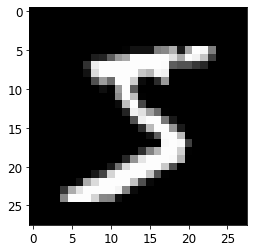

In [2]:
#MNIST DOWNLOAD
data_dir = os.path.expanduser('~/.pytorch-datasets')
mnist_train = torchvision.datasets.MNIST(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
mnist_test = torchvision.datasets.MNIST(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())
#Create BucketIterator for dataset
batch_size = 32

mdl_train = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True)
mdl_test = dl_train = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=True)


print(f'Train: {len(mnist_train)} samples')
print(f'Test: {len(mnist_train)} samples')

x0,y0 = mnist_train[0]
in_size = x0.shape
num_classes = 10
print('MNIST input image size =', in_size)
print(y0)
def to_image(x):
    return (x * torch.ones(3,28,28)).permute(1,2,0)
plt.imshow(to_image(x0))

X,y = next(iter(mdl_train))
X = X.reshape(X.size(0), -1) 
X.shape

CIFAR-10 Download

## Loading the model
We will now load the Linear Classifier model and test it's output

In [3]:
from LinearNetwork import LinearClassifier as FCModel
mnist_model = FCModel(in_size=784, out_classes=10, activation_type="relu", hidden_dims=[64,32])
mnist_model = mnist_model.to(device)

mnist_model

LinearClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)

## Performing experiments on the model
We will perform training on the original architecture persented at: https://arxiv.org/pdf/1812.09489.pdf on MNIST dataset, and other datasets with more features, we would later train and evaluate on the a new presented architecture.

In [4]:
# We will try two main architectures, both with RP layer at first,
# it is a Linear layer which does not train and it's weights are
# a RP matrix from our implemented module for Random Projection
import RandomProjection as RP
from Trainer import train_and_eval
# we will try varying projected dimension k for the MNIST problem
#experiment on different k's

In [5]:
#This code block saves results from our results data format, can put in a function
def Save_Results(results, rp_type, verbose=False, dataset="MNIST"):
    if verbose is True:
        for k in results.keys():
            print(f"Projected:{k}: train accuracy:{max(results[k][0])}, test accuracy:{max(results[k][1])}")

    file = open(f"Results/{dataset}_RP_{rp_type}.txt","w")
    file.write(json.dumps(results))
    file.close()

**Loading**<br/>We will load the results from files and in that case we would not retrain

In [6]:
projections = ["Gaussian","Achlioptas", "Li", "CountSketch", "SRHT"] #TODO: add SRHT, needs to add zero paddings to dataset
results = {}
for proj in projections:
    if not os.path.isfile(f"Results/MNIST_RP_{proj}.txt"):
        continue
    file = open(f"Results/MNIST_RP_{proj}.txt","r+")
    results[proj] = json.loads(file.read())
    file.close()

In any other case we retrain

In [7]:
krange = torch.logspace(1,9,9,base=2) #we test k's from 1 to 784 with multiplicative steps of 2
padding = 0
for proj in projections:
    if proj in results.keys(): #We would not retrain any model alreay trained (if krange list changed we would want to retrain)
        continue
    results[proj] = {}
    print(f"training for {proj}")
    if proj == "SRHT":
        padding = 1024-784 #TODO: make this line adaptive for input size
    for k in list(krange)[::1]:
        mnist_model = FCModel(in_size=784, out_classes=10, activation_type="relu", hidden_dims=[int(k/2)], rp=int(k), rp_type=proj, padding=padding).to(device)
        print(f"projected dimension:{int(k)}")
        #print(f"Model Architecture:{mnist_model}")
        lr = 1e-3
        optimizer = torch.optim.Adam(mnist_model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss().to(device)

        res = train_and_eval(mnist_model, mdl_train, mdl_test, optimizer, loss_fn, verbose=False)
        results[proj][str(int(k))] = res

training for SRHT
projected dimension:2


C:\Users\Admin\Documents\Technion\Tutorials\Mass Information\project\Code\LinearNetwork.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W, dtype=torch.float32)


KeyboardInterrupt: 

**We will save the results to a txt file**

In [ ]:
for proj in projections:
    print(proj)
    Save_Results(results[proj], proj)

## Graphs
## TODO: ADD SRHT !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Showing the results for different projection dimensions

For each Random Projection, we will display the best result in each measured parameter (i.e train and test loss and accuracy)

In [ ]:
final = {}
for proj in results.keys():
    final[proj] = {}
    for k in results[proj].keys():
        for i in range(4): # 4 different measurements of accuracy/loss
            temp = max(results[proj][k][i][:2]) if i <= 1 else min(results[proj][k][i][:2])
            if i in final[proj].keys():
                final[proj][i].append(temp)
            else:
                final[proj][i] = [temp]
            
krange = torch.logspace(1,9,9,base=2) #we test k's from 1 to 784 with multiplicative steps of 2

In [ ]:
def plot_results(results, arr, label="k", xscale="linear", xbase=2.0): #results- list of results from different models, each result is a list
    colors = ["red","blue","green","black","purple"]
    fig,_ = plt.subplots(nrows=2,ncols=2,sharex=True, figsize = (18,12))
    k = [int(i) for i in arr]
    for i, plot_type in enumerate(('train_acc', 'train_loss', 'valid_acc', 'valid_loss')):
        ax = fig.axes[i]
        if xscale == "log":
            ax.set_xscale(xscale, base=xbase)
        ax.set_yscale("linear")
        models_res = results[plot_type]
        idx = 0
        for model in models_res.keys():
            ax.plot(np.array(k), models_res[model], label=model, color=colors[idx])
            idx += 1
        ax.set_title(plot_type)
        ax.set_xlabel(label)
        ax.legend()
    return fig

In [ ]:
len(results["Li"]["32"][3])

In [ ]:
results_m = {'train_acc':None,'valid_acc':None,'train_loss':None,'valid_loss':None}
results_m['train_acc'] = {'Gaussian':final["Gaussian"][0],'Achlioptas':final["Achlioptas"][0],'Li':final["Li"][0], "Count-Sketch": final["CountSketch"][0]}
results_m['valid_acc'] = {'Gaussian':final["Gaussian"][1],'Achlioptas':final["Achlioptas"][1],'Li':final["Li"][1], "Count-Sketch": final["CountSketch"][1]}
results_m['train_loss'] = {'Gaussian':final["Gaussian"][2],'Achlioptas':final["Achlioptas"][2],'Li':final["Li"][2], "Count-Sketch": final["CountSketch"][2]}
results_m['valid_loss'] = {'Gaussian':final["Gaussian"][3],'Achlioptas':final["Achlioptas"][3],'Li':final["Li"][3], "Count-Sketch": final["CountSketch"][3]}

plot_results(results_m, krange, xscale="log", xbase=2.0);

**We will now print the convergance graphs of the model for different projection dimensions:**

In [ ]:
epochs = range(20)
for k in [32,64,128,256,512]:
    results_m = {'train_acc':None,'valid_acc':None,'train_loss':None,'valid_loss':None}
    results_m['train_acc'] = {'Gaussian':results["Gaussian"]["32"][0],'Achlioptas':results["Achlioptas"]["32"][0],'Li':results["Li"]["32"][0], "Count-Sketch": results["CountSketch"]["32"][0]}
    results_m['valid_acc'] = {'Gaussian':results["Gaussian"]["32"][1],'Achlioptas':results["Achlioptas"]["32"][1],'Li':results["Li"]["32"][1], "Count-Sketch": results["CountSketch"]["32"][1]}
    results_m['train_loss'] = {'Gaussian':results["Gaussian"]["32"][2],'Achlioptas':results["Achlioptas"]["32"][2],'Li':results["Li"]["32"][2], "Count-Sketch": results["CountSketch"]["32"][2]}
    results_m['valid_loss'] = {'Gaussian':results["Gaussian"]["32"][3],'Achlioptas':results["Achlioptas"]["32"][3],'Li':results["Li"]["32"][3], "Count-Sketch": results["CountSketch"]["32"][3]}
    plot_results(results_m, epochs, f"epoch; k={k}");

In the first graph (best accuracy to projected dimension) we can see that the difference in performance between the different methods is not major.<br/>
In the next graphs we can see clearly that for MNIST dataset, Achlioptas Random Projection performs better for a large enough amount of epochs, for a smaller number of epochs, Li's method performs better on the validation set, for a really small number of epochs we can see that the Gaussian Random Projection performs better than Achlioptas as well, Count-Sketch shows the least accuracy of all for this dataset, possibly because of the small input size (that would be tested later on a larger dataset).
A possible explanation of the results is that Li's Random Projection is similiar to Achlioptas but more sparse, this sparsity preserves less information but the information preserved is easier to learn from after very few epochs.

Downloading CIFAR-10

In [ ]:
#CIFAR-10 DOWNLOAD
data_dir = os.path.expanduser('~/.pytorch-datasets')
cifar10_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
cifar10_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())

print(f'Train: {len(cifar10_train)} samples')
print(f'Test: {len(cifar10_test)} samples')

x0,_ = cifar10_train[0]
in_size = x0.shape
num_classes = 10
print('CIFAR-10 input image size =', in_size)

## Download datasets (To be added)

<h4>Importing our experiments</h4>
Now, we will load our experiments module for testing the different architectures. 